In [37]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [3]:
plt.rcParams['axes.axisbelow'] = True

In [4]:
# Define constants
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 30
NUM_CLASSES = 5

In [5]:
from google.colab import drive
drive.mount('/content/drive')

# Define the file paths
folder_path = '/content/drive/My Drive/Colab Notebooks/flower_photos'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
def load_data(folder_path):
    X = []
    y = []
    class_names = [d for d in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, d))]
    print("Class names:", class_names)

    for i, class_name in enumerate(class_names):
        class_path = os.path.join(folder_path, class_name)
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            try:
                image = load_img(image_path, target_size=IMAGE_SIZE)
                image = img_to_array(image)
                X.append(image)
                y.append(i)
            except Exception as e:
                print(f"Error loading image {image_path}: {e}")
    X = np.array(X)
    y = np.array(y)
    return X, y, class_names

# Load the data
X, y, class_names = load_data(folder_path)

Class names: ['sunflowers', 'tulips', 'daisy', 'roses', 'dandelion']


Labels distribution:
Class: 0 , Count: 699 , Perc :18.9%
Class: 1 , Count: 799 , Perc :21.7%
Class: 2 , Count: 643 , Perc :17.4%
Class: 3 , Count: 651 , Perc :17.6%
Class: 4 , Count: 898 , Perc :24.3%


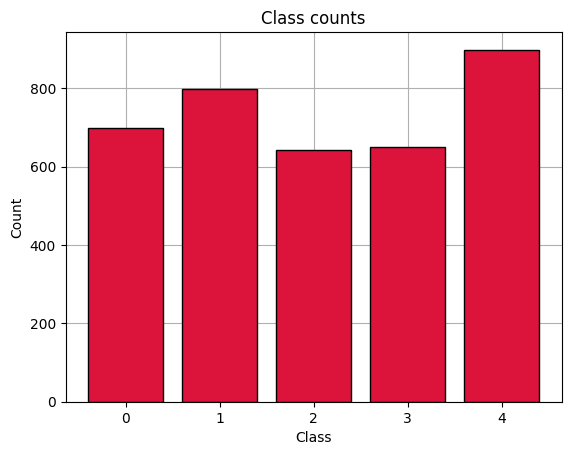

In [7]:
unique_classes, class_counts = np.unique(y, return_counts=True)

print('Labels distribution:')
for i in range(NUM_CLASSES):
    print('Class:', i, ', Count:', class_counts[i], ', Perc :{:.1f}%'.format(100*class_counts[i]/len(y)))

plt.bar(unique_classes, class_counts, edgecolor='black', color='crimson')
plt.title('Class counts')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(unique_classes)
plt.grid(True)
plt.show()

In [8]:
X_normalized = X/255.

In [9]:
from sklearn.model_selection import train_test_split

def split_data(X, y, train_size, val_size, test_size, random_state=None):
    """
    Splits data into train, validation, and test sets based on given sizes.

    Parameters:
    X (array-like): Features dataset.
    y (array-like): Labels dataset.
    train_size (float): Proportion of the dataset to include in the train split.
    val_size (float): Proportion of the dataset to include in the validation split.
    test_size (float): Proportion of the dataset to include in the test split.
    random_state (int, optional): Random seed for reproducibility.

    Returns:
    X_train, X_val, X_test, y_train, y_val, y_test: Split datasets.
    """

    if train_size + val_size + test_size != 1.0:
        raise ValueError("The sum of train_size, val_size, and test_size must be 1.0")

    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=(val_size + test_size), random_state=random_state)

    remaining_proportion = val_size / (val_size + test_size)

    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=(1 - remaining_proportion), random_state=random_state)

    return X_train, X_val, X_test, y_train, y_val, y_test

In [10]:
X_train, X_val, X_test, y_train, y_val, y_test = split_data(X_normalized, y,
                                                            train_size=0.8,
                                                            val_size=0.1,
                                                            test_size=0.1,
                                                            random_state=42)

In [13]:
del(X)
del(X_normalized)

# Convolutional Network

In [38]:
data_augmentation = keras.Sequential([
    keras.layers.experimental.preprocessing.RandomFlip('horizontal',input_shape = (224,224,3)),
    keras.layers.experimental.preprocessing.RandomRotation(0.2),
    keras.layers.experimental.preprocessing.RandomZoom(0.2)
])

In [39]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam

model = keras.models.Sequential([

    data_augmentation,

    keras.layers.Conv2D(filters = 16,kernel_size = (3,3) , activation = 'relu',padding = 'same'),
    keras.layers.MaxPool2D((3,3)),
    keras.layers.Conv2D(filters = 32,kernel_size = (3,3) , activation = 'relu'),
    keras.layers.MaxPool2D((3,3)),
    keras.layers.Dropout(0.2),
    keras.layers.Conv2D(filters = 64,kernel_size = (3,3) , activation = 'relu',padding = 'same'),
    keras.layers.MaxPool2D((3,3)),
    keras.layers.Conv2D(filters = 128,kernel_size = (3,3) , activation = 'relu',padding = 'same'),
    keras.layers.MaxPool2D((3,3)),
    keras.layers.Dropout(0.2),

    keras.layers.Flatten(),
    keras.layers.Dense(64,activation = 'relu'),
    keras.layers.Dense(32,activation = 'relu'),
    keras.layers.Dense(5,activation = 'softmax')
])

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 74, 74, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 24, 24, 32)        0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 24, 24, 32)       

In [40]:
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

y_train_encoded = to_categorical(y_train, NUM_CLASSES)
y_val_encoded = to_categorical(y_val, NUM_CLASSES)

early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

In [41]:
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train.reshape(-1)), y=y_train.reshape(-1))
class_weight_dict = dict(enumerate(class_weights))
print(class_weight_dict)

{0: 1.0953617810760667, 1: 0.9210608424336973, 2: 1.1160680529300566, 3: 1.1397683397683398, 4: 0.8143448275862069}


In [42]:
# Fit the model
history = model.fit(
    x=X_train,
    y=y_train_encoded,
    epochs=EPOCHS,
    validation_data=(X_val, y_val_encoded),
    #callbacks=[early_stopping],
    batch_size=BATCH_SIZE,
    #class_weight=class_weight_dict
)

Epoch 1/30
93/93 [==============================] - 11s 54ms/step - loss: 1.5012 - accuracy: 0.3072 - val_loss: 1.4054 - val_accuracy: 0.3496
Epoch 2/30
93/93 [==============================] - 3s 36ms/step - loss: 1.2076 - accuracy: 0.4915 - val_loss: 1.1475 - val_accuracy: 0.5664
Epoch 3/30
93/93 [==============================] - 3s 33ms/step - loss: 1.0186 - accuracy: 0.5742 - val_loss: 1.0244 - val_accuracy: 0.5962
Epoch 4/30
93/93 [==============================] - 3s 38ms/step - loss: 0.9248 - accuracy: 0.6216 - val_loss: 0.9905 - val_accuracy: 0.5935
Epoch 5/30
93/93 [==============================] - 3s 36ms/step - loss: 0.8872 - accuracy: 0.6247 - val_loss: 0.8838 - val_accuracy: 0.6287
Epoch 6/30
93/93 [==============================] - 3s 32ms/step - loss: 0.8405 - accuracy: 0.6470 - val_loss: 0.8344 - val_accuracy: 0.6612
Epoch 7/30
93/93 [==============================] - 3s 32ms/step - loss: 0.8154 - accuracy: 0.6701 - val_loss: 0.7979 - val_accuracy: 0.6585
Epoch 8/30
9

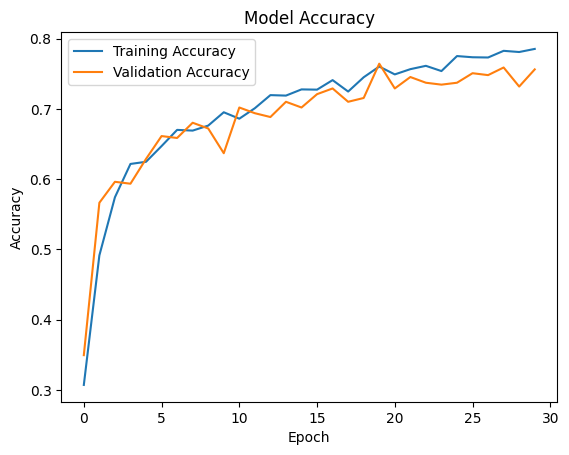

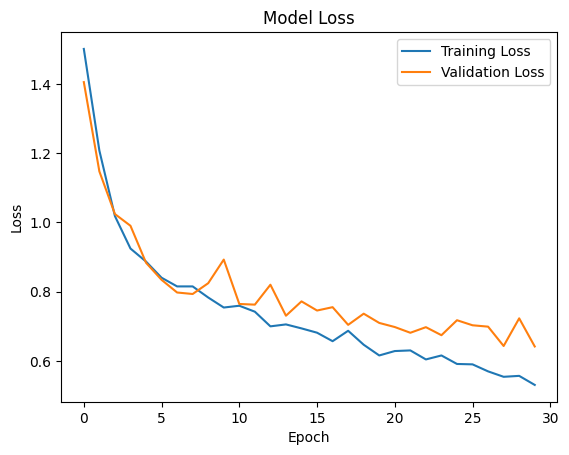

In [43]:
# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

12/12 [==============================] - 0s 12ms/step
Confusion Matrix:
[[73  4  1  1  2]
 [ 6 55  4 10  7]
 [ 0  2 48  2  1]
 [ 3 12  3 47  7]
 [ 5  2  7  4 63]]


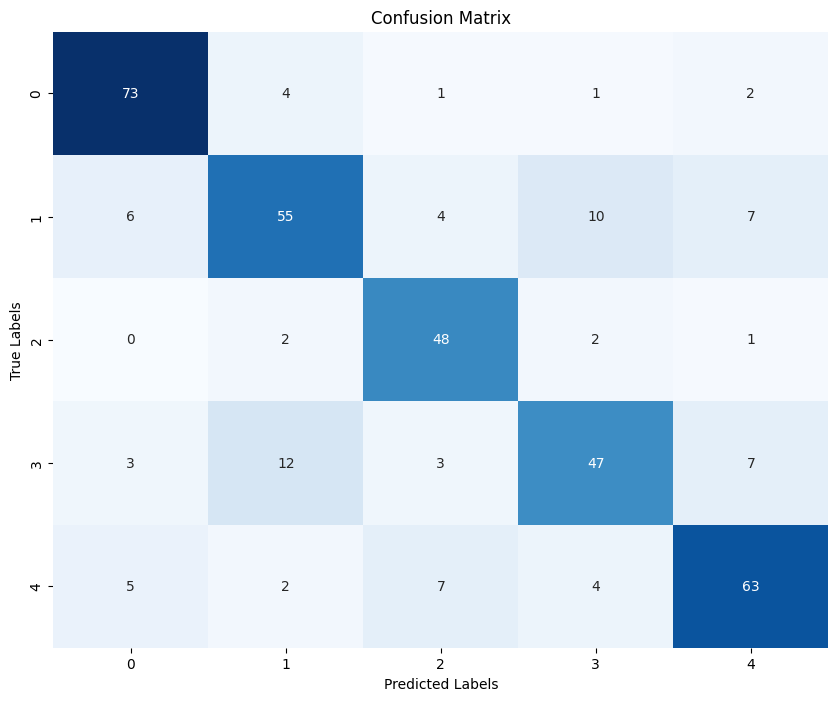

In [44]:
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns

y_pred = model.predict(X_test)

# Convert probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Now you can compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Print confusion matrix
print("Confusion Matrix:")
print(cm)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [45]:
# Compute F1 scores for each class
f1_scores = f1_score(y_test, y_pred_classes, average=None)
mean_f1_score = np.mean(f1_scores)

# Print F1 scores
print("F1 Scores for each class:")
for i, score in enumerate(f1_scores):
    print(f"Class {i}: {score:.2f}")

# Print mean F1 score
print(f"Mean F1 Score: {mean_f1_score:.2f}")

F1 Scores for each class:
Class 0: 0.87
Class 1: 0.70
Class 2: 0.83
Class 3: 0.69
Class 4: 0.78
Mean F1 Score: 0.77
